<a href="https://colab.research.google.com/github/Legacy560/MLTSA25_RWolynetz/blob/main/HW5/HW5_RWolynetz_chchchchanges_instructions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ruptures
import ruptures as rpt
import pylab as pl
import pandas as pd
import numpy as np
from scipy.optimize import minimize
%pylab inline




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.0 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


# Synthetic data
the cell below creates a synthetic dataset _(x,y)_ of 200 points, generated by two processes $ y =c + \epsilon$ with $\epsilon \sim N(0,1)$ (Gaussian stationary processes) that generate 100 points each with means 20 and 25 respectively.

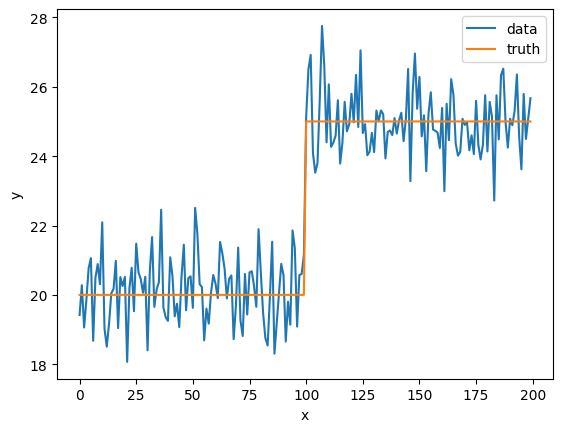

In [2]:
mu1, mu2 = 20, 25
x = np.arange(200)
ym = np.concatenate([np.random.randn(100) + mu1, np.random.randn(100) + mu2])
pl.plot(x, ym, label="data")
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, label="truth")
pl.xlabel("x")
pl.ylabel("y")
pl.legend();

In [3]:
ym.shape

(200,)

# Single POC -  difference of means
write a function that finds the POC by assuming a single POC and maximizing the differencem in the means before and after the POC as described in
https://slides.com/federicabianco/mltsa4#/6/1
test it on the synthetic dataset _(x,y)_

In [4]:
def maxdiff(y):
    """calculates the POC as the points that maximized the difference between the mean before and the mean after the POC
    y: vector of endogenouos variables

    """
    N = len(y) #Get length of vector y (the endogenous variables)
    f = np.nanmean #Representing this process by f. Easier to write.
    poc, diff, before, after = 0, 0, np.nan, np.nan
    for i in range(1, N):
        diff_here = np.abs(f(y[i:]) -  f(y[:i]))
        if diff < diff_here:
            diff = diff_here
            poc = i
            before, after = f(y[:i]), f(y[i:])
    return(poc, before, after)

print("poc: {:.2f}, mean before: {:.2f}, mean after: {:.2f}".format(*maxdiff(ym)))


poc: 100.00, mean before: 20.15, mean after: 24.99


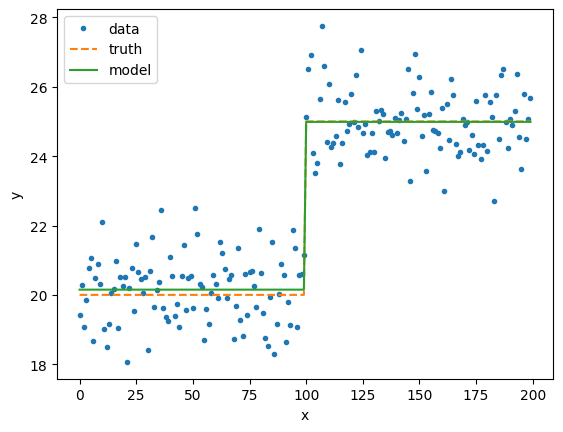

In [5]:
poc, before, after = maxdiff(ym)
pl.plot(x, ym, '.', label="data")
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, '--', label="truth")
pl.plot(x, [before] * poc + [after] * (len(ym) - poc), label="model")
pl.xlabel('x')
pl.ylabel('y');
pl.legend();

Figure 1: Here we have a plot of our time series as a scatterplot instead of as a line plot. The orange line represents the true mean of both of the above clusters. The green line represents the estimated mean of the clusters, while taking the POC into account using the maxdiff function. The first mean, 20 appears to be estimated correctly by the function, while the second, 25 appears to be just slightly underestimated.

# Single POC - MSE
write a function that finds the POC by minimizing the square error (see slide https://slides.com/federicabianco/mltsa4#/6/2) a single POC and maximizing the differencem in the means before and after the POC. like before return the index of the POC, the mean before and the mean after the POC.
Plot the data, the model, the truth, like in the step above.


Remember to write a docstring for the function https://www.python.org/dev/peps/pep-0257/!

In [6]:
def poc_mse(y):
    '''
    This function finds the POC by minimizing the square error and maximizing the difference
    in the means before and after the POC.
  Input:
    y: vector of endogenouos variables
    Output:
    poc: index of the POC
    before: mean before the POC
    after: mean after the POC
    '''
    N = len(y) #Get length of vector y (the endogenous variables)
    f = np.nanmean #Representing this process by f. Easier to write.
    poc, diff, before, after = 0, 0, np.nan, np.nan
    mse = float('inf')
    for i in range(1, N):
        meanBef = f(y[:i])
        meanAft = f(y[i:])
        mseHere = np.sum((y[:i] - meanBef)**2) + np.sum((y[i:] - meanAft)**2) #Compute MSE. The Frequentist Approach
        diff_here = np.abs(meanAft -  meanBef)

        if diff_here > diff and mse > mseHere: #We use an and operator here to ensure both conditions are met.
            diff = diff_here
            mse = mseHere
            poc = i
            before, after = meanBef, meanAft
    return(poc, before, after)



    return poc, before, after

In [7]:

print("poc: {:.2f}, mean before: {:.2f}, mean after: {:.2f}".format(*poc_mse(ym)))


poc: 100.00, mean before: 20.15, mean after: 24.99


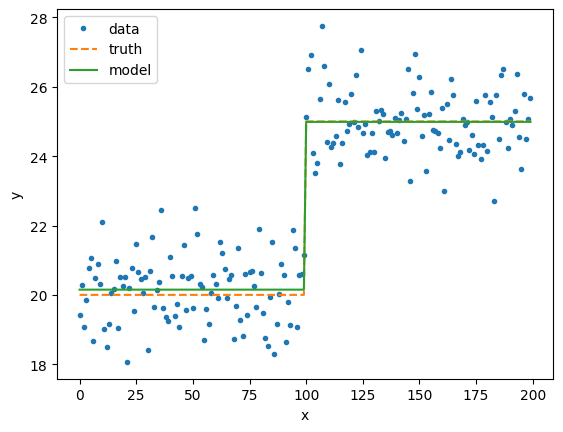

In [8]:
poc, before, after = poc_mse(ym)
pl.plot(x, ym, '.', label="data")
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, '--', label="truth")
pl.plot(x, [before] * poc + [after] * (len(ym) - poc), label="model")
pl.xlabel('x')
pl.ylabel('y');
pl.legend();

Figure 2: Here we have a plot of the same time series. This time the model uses the frequentist approach to find the POC as described in the poc_mse function. We can see that the estimations are identical as in the case with the chance in mean.

# Single POC - diff of variance
Generate a new synthetic dataset _(x,ys)_ of 200 points, generated by two processes $ y =c + \epsilon$ with $\epsilon \sim N(\sigma,1)$ (Gaussian stationary processes) that generate 100 points each with means 20 and variance 1 and 4 respectively.

Modify the ```maxdiff()``` function so that it take an optional parameter sigma which allows you to use the function to choose the POC that maximizes the different in standard deviation, instead of in mean. An optional argument is an argument that is set to a default in the function call. The default behavior of the function shoudl still be to calculate the POC as the point that maximized the before and after difference in the _mean_.


In [9]:
mu1, mu2 = 20, 25
s2 = 4
ys = np.concatenate([np.random.randn(100)  + mu1 , np.random.randn(100) * s2 + mu1])
ys.shape

(200,)

In [10]:

def maxdiff2(y, sigma = False):
    """calculates the POC as the points that maximized the difference between
                the mean or variance before and the mean after the POC
    y: vector of endogenouos variables
    sigma: finds the POC that maximizes the difference between before/after POC variance
                (optional, default is before/after mean)
    """
    N = len(y) #Get length of vector y (the endogenous variables)
    if sigma:
      f = np.nanstd
    else:
      f = np.nanmean #Representing this process by f. Easier to write.
    poc, diff, before, after = 0, 0, np.nan, np.nan
    for i in range(1, N):
        diff_here = np.abs(f(y[i:]) -  f(y[:i]))
        if diff < diff_here:
            diff = diff_here
            poc = i
            before, after = f(y[:i]), f(y[i:])
    return(poc, before, after)


print("poc: {:.2f}, Standard deviation before: {:.2f}, Standard Deviation after: {:.2f}".format(*maxdiff2(ys,
                                                                    sigma=True)))


poc: 101.00, Standard deviation before: 1.01, Standard Deviation after: 4.56


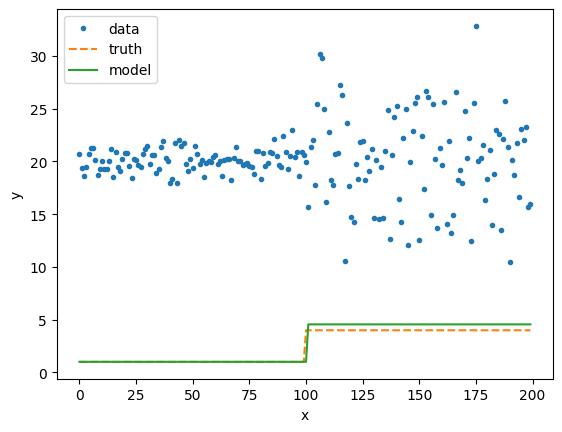

In [11]:
poc, before, after = maxdiff2(ys, sigma = True)
pl.plot(x, ys, '.', label="data")
pl.plot(range(200), [1] * 100 + [s2] * 100, '--', label="truth")
pl.plot(x, [before] * poc + [after] * (len(ys) - poc), label="model")
pl.xlabel('x')
pl.ylabel('y');
pl.legend();

Figure 3: Here we have another plot of our new dataset, with both clusters of points featuring the same means, but with variances 1 and 4 respectively. The truth and model lines are now drawn from the maxdiff2 function, which is set up to find the POC using the standard deviations instead. We can see that our model does a good job of estimating the standard deviations and the POC judging by how the two lines overlap.

Choose any of the function above and instead of optimizing them with a ``brute force'' method (i.e. with a for loop), use the `scipy.optimize.minimize` function (as done in the notebook about fitting lines to data).

<ipython-input-12-b192333a85bc>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(round(i))  # Ensure i is an integer, it is an index after all.


poc: 100.00, mean before: 20.15, mean after: 24.99


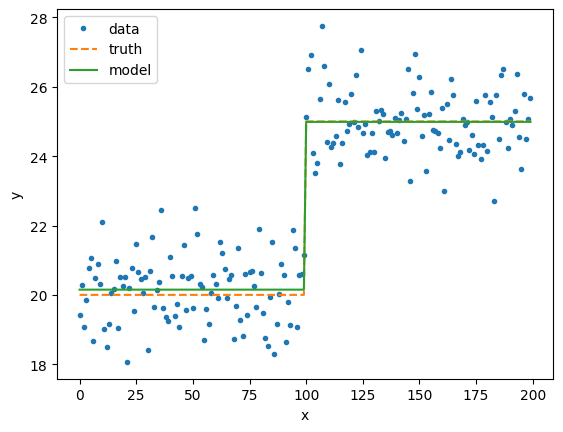

In [12]:
# prompt: use scipy.optimize.minimize to find the difference in means for the data ys just like in the max diff function


def maxdiff_minimize(y):
    """
    Calculates the POC by minimizing the negative difference in means using scipy.optimize.minimize.
    y: vector of endogenous variables
    Returns:
    poc: index of the POC
    before: mean before the POC
    after: mean after the POC
    """
    def objective_function(i):
        i = int(round(i))  # Ensure i is an integer, it is an index after all.
        if not (0 < i < len(y)): #Narrowws our guesses to within the data set indices
            return 0  # Return 0 for out-of-bounds values
        return -np.abs(np.nanmean(y[i:]) - np.nanmean(y[:i]))
        #The use of the - sign means we are minimizing the negative difference, which is equivalent to
        #maximizing the difference.

    # Initial guess
    initial_guess = len(y) // 2

    # Constraints
    bounds = [(1, len(y) - 1)] #The range of our whole search space

    # Optimization using minimize
    result = minimize(objective_function, initial_guess, bounds=bounds)

    poc = int(round(result.x[0]))
    before = np.nanmean(y[:poc])
    after = np.nanmean(y[poc:])

    return poc, before, after

print("poc: {:.2f}, mean before: {:.2f}, mean after: {:.2f}".format(*maxdiff_minimize(ym)))

poc, before, after = maxdiff_minimize(ym)
pl.plot(x, ym, '.', label="data")
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, '--', label="truth")
pl.plot(x, [before] * poc + [after] * (len(ym) - poc), label="model")
pl.xlabel('x')
pl.ylabel('y');
pl.legend();


Figure 4: Here we have plotted the dataset ym once again. This time, we use an optimization routine to locate the index where the POC occurs. Afterwards, the mean is computed before and after the POC. We can see that our model does a good job of estimating the means and the POC judging by how the two lines overlap.

# Find POC with rupture python package.
install and import the rupture package.
Find the POC in each synthetic time series.
Use the Pelt method. Reflect on the parameters that should be passed to the predict() function. Read the manual and feel free to ask questions on slack.

In [13]:
rpt.Pelt?

#ym

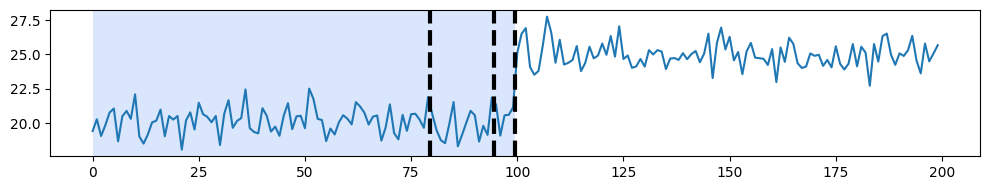

In [14]:
# detection
algo = rpt.Pelt(model="l1").fit(ym) #using l1 norm
result = algo.predict(pen=1)
#The higher the penalty, the fewer change points will be identified. Smaller penalties will make the
#algorithm more sensitive to smaller changes.

# display
rpt.display(ym, [100], result)
pl.show()

Figure 5: Plot of ym, with the POC's penalized at a parameter of 1. We can see here that the algorithm is very sensitive to any slight change in the mean, interpreting such changes as a POC.

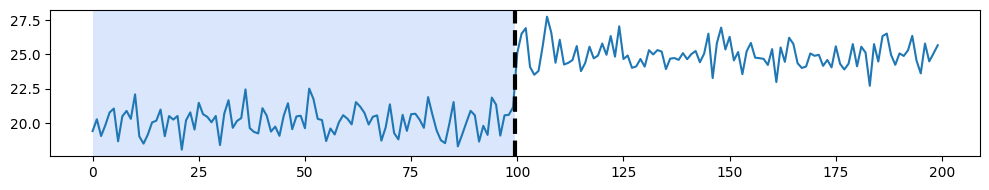

In [15]:
# detection
algo = rpt.Pelt(model="l1").fit(ym) #using l1 norm
result = algo.predict(pen=3)
#The higher the penalty, the fewer change points will be identified. Smaller penalties will make the
#algorithm more sensitive to smaller changes.

# display
rpt.display(ym, [100], result)
pl.show()

Figure 6: Plot of dataset, ym, with the POC estimated using the rupture package with a penalty of 4. The l1 objective function is used for estimation. The POC is almost perfectly estimated here.

We can see here that increasing the penalty, decreases the algorithm's sensitivity to smaller changes in the mean. This means that only larger POC's will be identified, which was exactly our goal here.

#ys

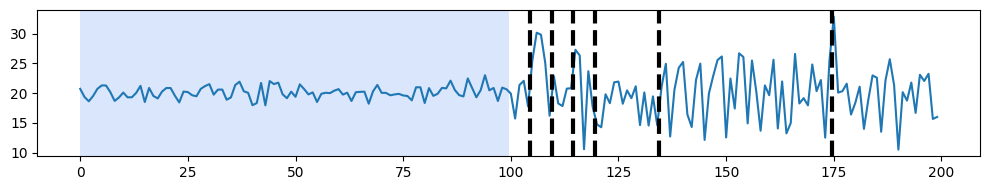

In [16]:
# detection
algo = rpt.Pelt(model="rbf").fit(ys) #rbf identifies change in variance
result = algo.predict(pen = 1)

# display
rpt.display(ys, [100], result)
pl.show()

Figure 7: Plot of dataset, ys, with the POC estimated using the rupture package. The penalty is 1. The rbf objective function is used for estimation of the variance. Once again, the algorithm is sensitive to any slight changes in the variance of the dataset and identifies those changes as POCs.

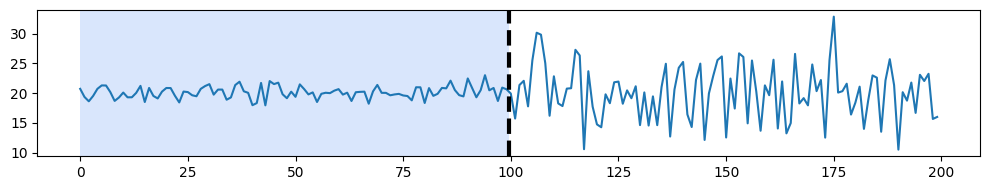

In [17]:
# detection
algo = rpt.Pelt(model="rbf").fit(ys) #rbf identifies change in variance
result = algo.predict(pen = 2)

# display
rpt.display(ys, [100], result)
pl.show()

Figure 7: Plot of dataset, ys, with the POC estimated using the rupture package. The rbf objective function is used for estimation. The POC is almost perfectly estimated here. Here, we increased the penalty to 2, decreasing the algorithm's sensitive to smaller changes while still identifying the POC we are interested in.

We can see that, over both datasets, the penalty parameter in the predict function is controlling how many points of change the algorithm identifies. The higher the penalty, the less sentitive the algorithm is to POCs. Thus, to identify true POCs, in general, we must use a high penalty in our predictions.

# read in the data from LANL earthquake prediction
I saved in the github repo as "http://fbb.space/mltsa/LALNeq.csv. This is a large file and will take a long time to read in. It is 1/100th of the original file. See how nice I am!?! https://www.kaggle.com/c/LANL-Earthquake-Prediction/data

Visualize and use the method DataFrame.describe() to extract some basic statistics of the dataset

In [18]:
eq1 = pd.read_csv("http://fbb.space/mltsa/LALNeq.csv", index_col=0)

eq1.describe()

,acoustic_data,time_to_failure
count,4.500000e+06,4.500000e+06
mean,4.616407e+00,8.852012e-01
std,2.614006e+01,3.374432e-01
min,-4.621000e+03,3.008971e-01
25%,2.000000e+00,5.934956e-01
50%,5.000000e+00,8.849986e-01
75%,7.000000e+00,1.177597e+00
max,3.252000e+03,1.469100e+00


In [19]:
eq1.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


# using rupture

Go through the documentation of rupture.

Find a method that takes as input the number of pocs and has computational complexity O(kN^2) THAT METHOD IS DYNP and run it for k=1,2,3 pocs on the first N=10,000, 5000, and 1000 rows of the datasets respectively (make a plot for each and discuss each in the caption)




In [20]:
rpt.Dynp?

#N = 10000

/usr/local/lib/python3.11/dist-packages/ruptures/costs/costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


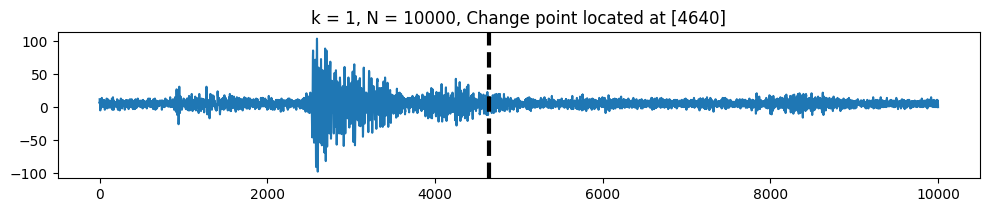

In [21]:
#k = 1
algo11 = rpt.Dynp(model="normal").fit(eq1.acoustic_data.values[:10000])
result11 = algo11.predict(n_bkps=1) #n_bkps: the number of change points

# display
rpt.display(eq1.acoustic_data.values[:10000], [], result11)
plt.title(f"k = 1, N = 10000, Change point located at {result11[:-1]}")
plt.show()


Figure 8: k = 1, N = 10000. This is a plot of the earthquake time series using the Dynp (Dynamic programming) method from rupture, which uses the specified computational complexity. Here we've asked for only one POC to be identified (the dashed black line). The model seems to be slightly off in the detection, as we can see that the true POC is slightly left of the prediction.



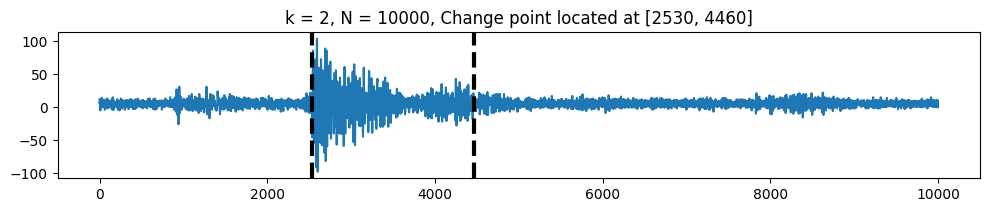

In [22]:
# k = 2
algo12 = rpt.Dynp(model="normal").fit(eq1.acoustic_data.values[:10000])
result12 = algo12.predict(n_bkps=2) #n_bkps: the number of change points

# display
rpt.display(eq1.acoustic_data.values[:10000], [], result12)
plt.title(f"k = 2, N = 10000, Change point located at {result12[:-1]}")
plt.show()


k = 2, n = 10000. We have now identified 2 POCs. The one to the left appears to be pretty accurate, as we can see that the variance changes significantly at that point. The one on the right is approximated more accuratly than before, as it is now positioned more to the left.





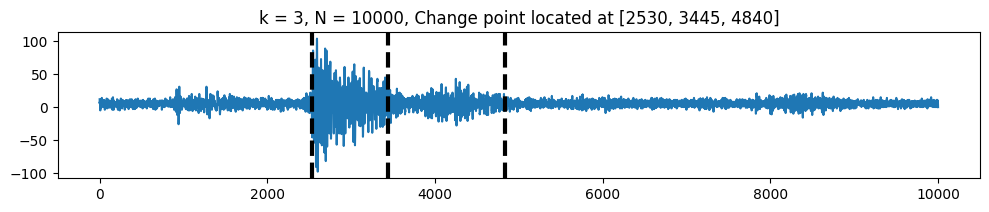

In [23]:
# k = 3
algo13 = rpt.Dynp(model="normal").fit(eq1.acoustic_data.values[:10000])
result13 = algo13.predict(n_bkps=3) #n_bkps: the number of change points

# display
rpt.display(eq1.acoustic_data.values[:10000], [], result13)
plt.title(f"k = 3, N = 10000, Change point located at {result13[:-1]}")
plt.show()


k = 3, n = 10000. There are now 3 POCs identified. The first 2 POCs, from the left, appear to be mostly accurate (the first is the same point as before). The last POC on the right is less accurate, as it is further to the right from where it should be.

#N = 5000

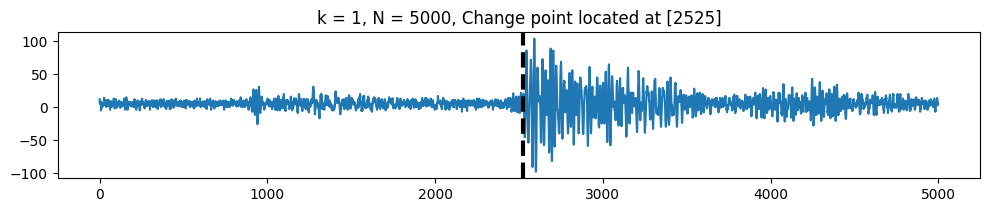

In [24]:
k = 1
algo21= rpt.Dynp(model="normal").fit(eq1.acoustic_data.values[:5000])
result21 = algo21.predict(n_bkps=1) #n_bkps: the number of change points

# display
rpt.display(eq1.acoustic_data.values[:5000], [], result21)
plt.title(f"k = {k}, N = 5000, Change point located at {result21[:-1]}")
plt.show()

Figure 9: We now have a plot of the first 5000 rows of our dataset. We have identified one POC here. The POC is just to the left of where it should be, although, visually, there is some change in the variance on both sides of the line.

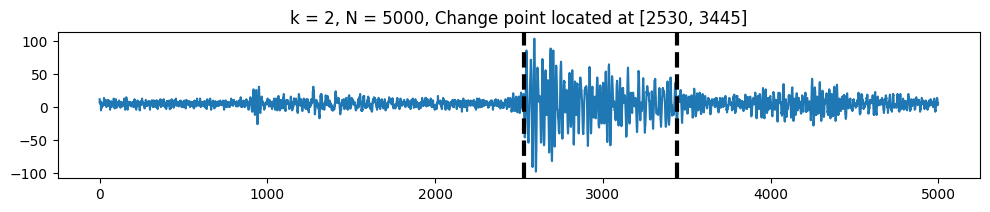

In [25]:
k = 2
algo22= rpt.Dynp(model="normal").fit(eq1.acoustic_data.values[:5000])
result22 = algo22.predict(n_bkps=k) #n_bkps: the number of change points

# display
rpt.display(eq1.acoustic_data.values[:5000], [], result22)
plt.title(f"k = {k}, N = 5000, Change point located at {result22[:-1]}")
plt.show()

k = 2. N = 5000. Two POCs are now identified. The first one on the left, is estimated more accuratly than in the last case. The second one appears to be visually accurate as well.

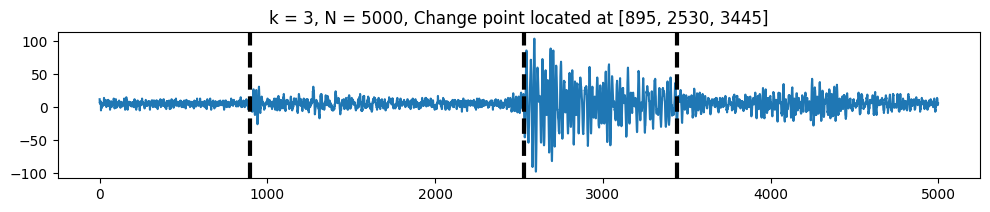

In [26]:
k = 3
algo23= rpt.Dynp(model="normal").fit(eq1.acoustic_data.values[:5000])
result23 = algo23.predict(n_bkps=3) #n_bkps: the number of change points

# display
rpt.display(eq1.acoustic_data.values[:5000], [], result23)
plt.title(f"k = {k}, N = 5000, Change point located at {result23[:-1]}")
plt.show()

k = 3, n = 5000. There are now 3 POCs, all ow which appear to be estimated accuratly, based on the appearance of the plot. The two points to the right have not changed from the previous case.

#N = 1000

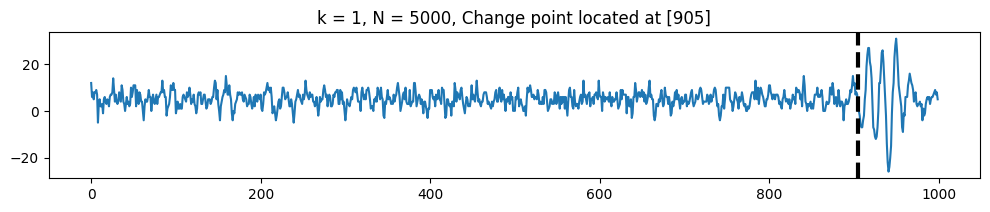

In [27]:
k = 1
algo31= rpt.Dynp(model="normal").fit(eq1.acoustic_data.values[:1000])
result31 = algo31.predict(n_bkps=1) #n_bkps: the number of change points

# display
rpt.display(eq1.acoustic_data.values[:1000], [], result31)
plt.title(f"k = {k}, N = 5000, Change point located at {result31[:-1]}")
plt.show()

Figure 10: k = 1, n = 1000. We now examine the first 1000 rows of the dataset. One POC is identified just before the large cluster off to the far right of the plot. This cluster is the same one as shown in the far left of the plot from the plot of the first 5000 rows, where the estimate of this POC was further left from where it is now.

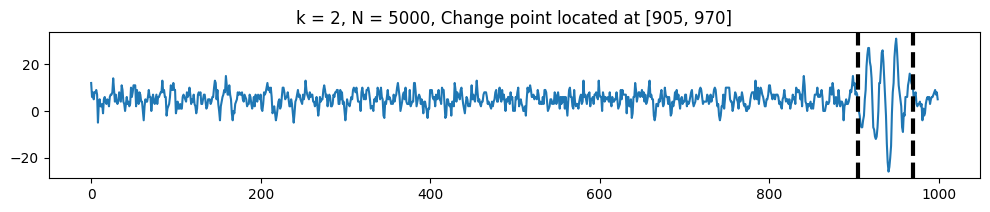

In [28]:
k = 2
algo32= rpt.Dynp(model="normal").fit(eq1.acoustic_data.values[:1000])
result32 = algo32.predict(n_bkps=2) #n_bkps: the number of change points

# display
rpt.display(eq1.acoustic_data.values[:1000], [], result32)
plt.title(f"k = {k}, N = 5000, Change point located at {result32[:-1]}")
plt.show()

k = 2, n = 1000.  One POC is identified just before the large cluster off to the far right of the plot. The second is identified after this cluster on the right. The POC on the left remains at the same index as in the previous case.

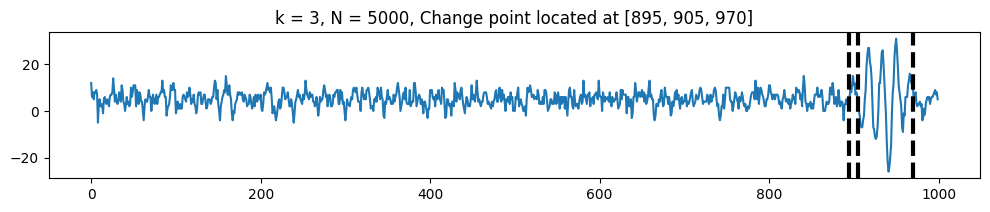

In [29]:
k = 3
algo33= rpt.Dynp(model="normal").fit(eq1.acoustic_data.values[:1000])
result33 = algo33.predict(n_bkps=3) #n_bkps: the number of change points

# display
rpt.display(eq1.acoustic_data.values[:1000], [], result33)
plt.title(f"k = {k}, N = 5000, Change point located at {result33[:-1]}")
plt.show()

k = 3, n = 1000.  Both POCs from the previous case are located at the same indices. The third one at 895 was also identified in the n = 5000 case. It seems that the estimations get more accurate with smaller sizes of datasets.

Find a method that has computational complexity O(Nlog(N)) BOTTOMUP

Run both methods on the full 10000 rows dataset with the goal is to isolate 3 chunks of the time series. Read about the methods you choose, and describe the constraints you imposed and the paraemters you choose.

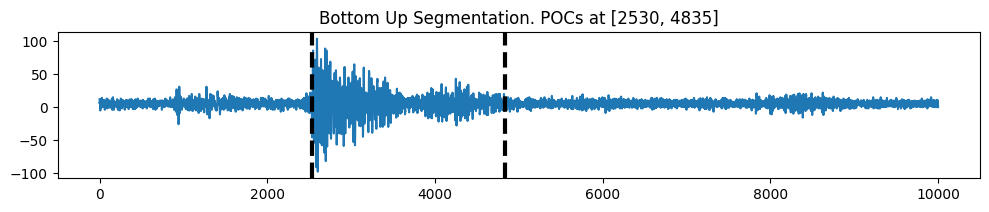

In [30]:
#Using Bottom Up Segmentation
N = 10000
algoA = rpt.BottomUp(model="normal").fit(eq1.acoustic_data.values[:N])
resultA = algoA.predict(n_bkps=2) #n_bkps: the number of change points

# display
rpt.display(eq1.acoustic_data.values[:N], [], resultA)
plt.title(f"Bottom Up Segmentation. POCs at {resultA[:-1]}")
plt.show()

Figure 11: Segmentation performed using the Bottom Up method. Two POCs were detected, one at index 2530 and the other at 4835. In order to segment the data into 3 sections, n_bkps (The number of POCs) was set to two, hence the identification of 2 POCs. The normal equation was used as the objective function as it shorteded the runtime of the algorithm when compared to the radial basis function.

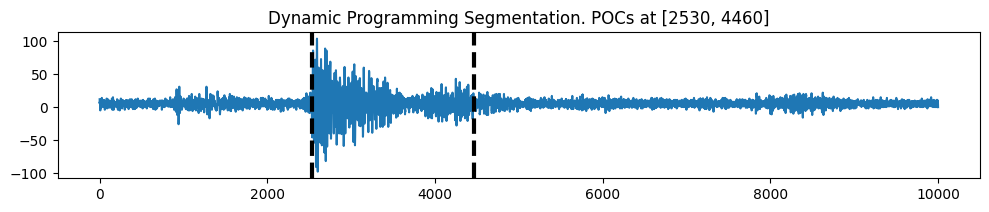

In [31]:
#Using Dynamic Programming
algoB = rpt.Dynp(model="normal").fit(eq1.acoustic_data.values[:N])
resultB = algoB.predict(n_bkps=2) #n_bkps: the number of change points

# display
rpt.display(eq1.acoustic_data.values[:N], [], resultB)
plt.title(f"Dynamic Programming Segmentation. POCs at {resultB[:-1]}")
plt.show()

Figure 12: Segmentation performed using the Dynamic Programming method. Two POCs were detected, one at index 2530 and the other at 4460 (This is further left from where this point was in the previous case). In order to segment the data into 3 sections, n_bkps (The number of POCs) was set to two, hence the identification of 2 POCs. The normal equation was used as the objective function as it shorteded the runtime of the algorithm when compared to the radial basis function.